# PyAMOC

Python version of AMOC curve, based on translation from [R  implementation](https://miningthedetails.com/blog/r/AMOC/).

For details on AMOC implementation, see Fawcett and Provost, [Activity Monitioring: Noticing Interesting Behavior](https://dl.acm.org/doi/abs/10.1145/312129.312195)

In [1]:
import pandas as pd
import matplotlib
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

## Test data generation code

In [2]:
def generate_spike(maxlen,spike_length = 100, stdev = 1, mean = 0):
    # randomly select a starting point for positive activity
    spike_start  =  random.randint(1,maxlen)
    spike_end    = spike_start + spike_length
   
    # create the baseline signal
    base = np.zeros(spike_start)
    sinwave = np.sin(np.arange(0, 1, 1/spike_length))
    vals = np.concatenate([base,sinwave])
   
    #perturb to add noise
    noise = np.random.normal(mean,stdev,spike_end)
    y = vals+noise
    
    # normalize to 0..1
    #y  /= np.max(np.abs(y),axis=0)
    y = (y-np.min(y))/np.ptp(y)

    # create labeled data for activity
    # first on the base
    positive = np.zeros(len(base))
    # then on the spike
    positive_spike = np.ones(len(sinwave))
    positive =  np.concatenate([positive,positive_spike])
    return(pd.DataFrame({"x": np.arange(len(y)),"y":y,"positive":positive}))


def generate_data_set(spike_length=100):
    ids = range(1,101)
    # create empty data frame
    xmax  =1000 
    res=[]
    
    for ID in ids:
        g = generate_spike(xmax,spike_length)
        res.append((ID,g))
    return res

In [3]:
g=generate_spike(1000,100)
g

,x,y,positive
0,0,0.499099,0.0
1,1,0.388590,0.0
2,2,0.280306,0.0
3,3,0.606771,0.0
4,4,0.523219,0.0
...,...,...,...
428,428,0.750961,1.0
429,429,0.451491,1.0
430,430,0.879401,1.0
431,431,0.862123,1.0


In [4]:
g['y'].max()

1.0

In [5]:
g['y'].min()

0.0

## calculating and graphing results

In [6]:
def get_cumulative_sum(y,reference):
    n = len(y)
    s = [0]*n
    s=np.zeros(n)
    if(n==1):
        return(np.array(s))

    for i in range(2,n):
        s[i] = max(0,s[(i-1)] + y[i]-reference[i]) 
    return(np.array(s))

def summarize_sequence(ID,g):
    x = g["x"]
    y = g["y"] 
    positive  = g['positive']
      
    reference = np.cumsum(y)/np.arange(1,len(y)+1)
    s = get_cumulative_sum(y, reference)
    ids = np.repeat(ID,len(y))
    temp = pd.DataFrame({'ID':ids,
                             'x':x,
                             'y':y,
                             'reference':reference,
                             's':s,
                             'positive':positive})
    return temp

# summarize_dataset 
# score_list is a list of tuples of ID and tables/data frame
# each data frame has an index column, a y value (score) and a a truth value 
# labeled "positive"  - 0 if false, 1 if true
def summarize_dataset(score_list):
    ds = pd.DataFrame(columns=['ID','x','y','reference','s','positive'])
  
    for entry in score_list:
        ID =entry[0]
        # sequence
        g =entry[1]
        temp = summarize_sequence(ID,g)
        ds = pd.concat([ds,temp])
    return ds

# must call gen_scores on result
# cutoff is threshold - when do we stop detection?
def gen_scores(ds,cutoff=100):
    thresholds  = list(np.arange(-10,120,0.5))
    rows=[]
    # score function 
    # 1 - alarm triggered within 100 samples of the onset of positive
    # activity
    # 0 - all other scenarios
    for t in thresholds: 
        ds['detected']=ds['s']>t
        ds['false_alarm']=(ds['detected']== True) & (ds['positive']==0)
        ds['score']=(ds['detected']==True) & (ds['positive']==1)
     
        ds['false_alarm']=ds['false_alarm'].replace({True:1,False:0})
        
        ds['score']=ds['score'].replace({True:1,False:0})
        
        scores = ds.groupby('ID')['score'].max()
        false_alarm_sum = ds.groupby('ID')['false_alarm'].sum()
        samples = ds.groupby('ID')['x'].count()- cutoff
    
        #calculate summaries
        false_alarm_rate = sum(false_alarm_sum)/sum(samples)
        total_score      = scores.mean()

        rows.append([t,false_alarm_rate,total_score])
        
    final_scores = pd.DataFrame(rows,columns=['threshold','false_alarm_rate','score'])
    return final_scores

def score_dataset(res,cutoff=100):
    ds= summarize_dataset(res)
    scores = gen_scores(ds,cutoff)
    return scores

def gen_plot(final_scores):
    scores.plot(x="false_alarm_rate",y="score",xlabel ="False Alarm Rate", ylabel="Average score",marker="o",mec="#E4002B",color="#7A99AC") 
    plt.title("Activity Monitor Operating Characteristic (AMOC)")
    ax=plt.subplot()
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)

### input

Input is a list of tuples.
Each tuple has an integer ID and then a DataFrame
The data Frame has three columns:
1. x -  the index in the list
2. y -  the value being monitored at that time point
3. positive - Truth value - 1 if the event is observed, 0 if not.

In [7]:
res = generate_data_set()

In [8]:
res[0]

(1,
        x         y  positive
 0      0  0.521857       0.0
 1      1  0.371308       0.0
 2      2  0.323492       0.0
 3      3  0.371862       0.0
 4      4  0.417019       0.0
 ..   ...       ...       ...
 867  867  0.619892       1.0
 868  868  0.403118       1.0
 869  869  0.363173       1.0
 870  870  0.528770       1.0
 871  871  0.792766       1.0
 
 [872 rows x 3 columns])

### Given these numbers, call get the scores

call `summarize_dataset` and then `gen_scores`. 


`gen_scores` takes a second argument - the size of the data at the end of the sequence that will be excluded

The larger this is, the earlier the prediction is, and  (presumably) the worse the prediction is.

Or just call `score_dataset`

In [9]:
ds= summarize_dataset(res)
scores = gen_scores(ds,100)
scores

,threshold,false_alarm_rate,score
0,-10.0,1.0,1.0
1,-9.5,1.0,1.0
2,-9.0,1.0,1.0
3,-8.5,1.0,1.0
4,-8.0,1.0,1.0
...,...,...,...
255,117.5,0.0,0.0
256,118.0,0.0,0.0
257,118.5,0.0,0.0
258,119.0,0.0,0.0


In [10]:
scores= score_dataset(res)
scores

,threshold,false_alarm_rate,score
0,-10.0,1.0,1.0
1,-9.5,1.0,1.0
2,-9.0,1.0,1.0
3,-8.5,1.0,1.0
4,-8.0,1.0,1.0
...,...,...,...
255,117.5,0.0,0.0
256,118.0,0.0,0.0
257,118.5,0.0,0.0
258,119.0,0.0,0.0


---
scratch

---

### plot the results

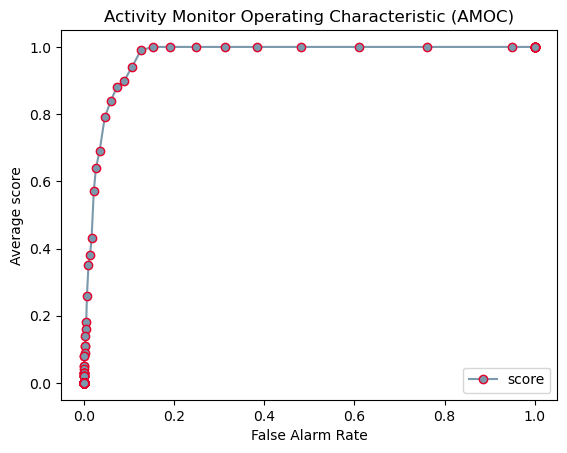

In [11]:
gen_plot(scores)

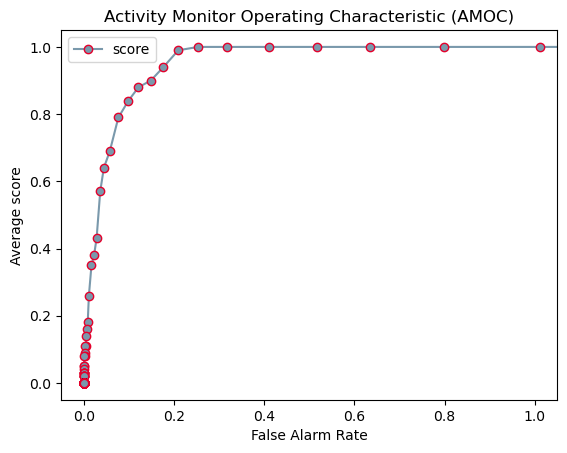

In [14]:
scores= score_dataset(res,300)
gen_plot(scores)

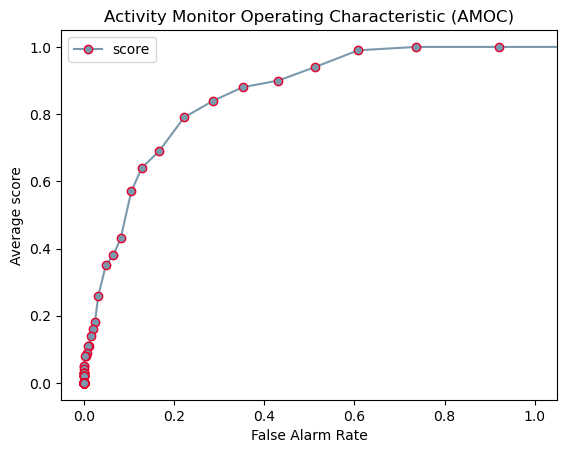

In [15]:
scores= score_dataset(res,500)
gen_plot(scores)

# Alternative implementation based more closely on Fawcette and Provost

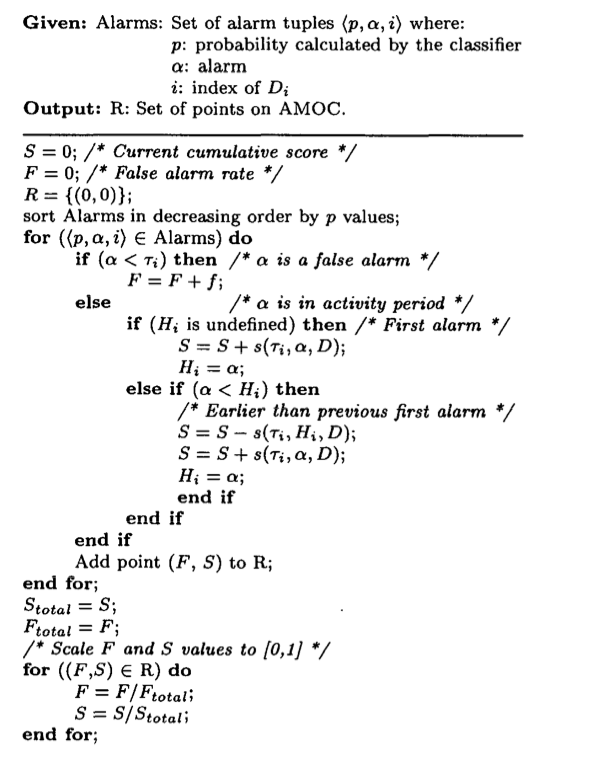

In [12]:
Image("images/amoc-algorithm.png")